# Hamilton Spatial Analysis (Python / Jupyter)

This notebook will:

1. Load Hamilton (NZ) spatial boundaries (TA & SA2).  
2. Count convenience stores, thefts, and police-stations by SA2.  
3. Merge in census & unemployment data.  
4. Visualize with Folium and Seaborn.  
5. Fit OLS and spatial lag models using PySAL.


In [5]:
pip install pysal

Note: you may need to restart the kernel to use updated packages.


# Step 0: Imports and Configuration

In [35]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
import statsmodels.formula.api as smf

%matplotlib inline

# Step 1: Load Territorial Authority Boundaries
#### 1.1 Load the territorial boundary
Read the 2022 TA shapefile, then filter to just the Hamilton City polygon

In [8]:
t_boundary = gpd.read_file("territorial-authority-2022-clipped-generalised.shp")
ta_hamilton = t_boundary[t_boundary["TA2022_V_1"].str.contains("Hamilton City", case=False)]


#### 1.2 Load Statistical Area 2 Boundaries & clip to Hamilton
Read SA2s, clips them to Hamilton's boundary, and reprojects to a local metric CRS

In [9]:
stat_area = gpd.read_file("statistical-area-2-2023-generalised.shp")
# intersect SA2 with Hamilton TA to get only Hamilton SA2s
sa2_hamilton = gpd.overlay(stat_area, ta_hamilton, how="intersection", keep_geom_type=False)
# project to NZTM2000 for accurate area calculations
sa2_hamilton = sa2_hamilton.to_crs(epsg=2193)
sa2_hamilton.head()

,SA22023_V1,SA22023__1,SA22023__2,LAND_AREA__1,AREA_SQ_KM_1,Shape_Leng_1,TA2022_V1_,TA2022_V_1,TA2022_V_2,LAND_AREA__2,AREA_SQ_KM_2,Shape_Leng_2,geometry
0,180000,Hamilton East Cook,Hamilton East Cook,0.733584,0.733584,3570.961168,016,Hamilton City,Hamilton City,110.373134,110.936733,70459.395035,"POLYGON ((1803151.467 5815121.022, 1803195.511..."
1,172900,Rotokauri,Rotokauri,15.644236,15.644236,27619.750096,016,Hamilton City,Hamilton City,110.373134,110.936733,70459.395035,"MULTILINESTRING ((1792538.274 5820417.664, 179..."
2,175301,Flagstaff North West,Flagstaff North West,0.940643,0.940643,4556.115933,016,Hamilton City,Hamilton City,110.373134,110.936733,70459.395035,"POLYGON ((1797680.910 5822836.372, 1797715.887..."
3,176800,Crawshaw,Crawshaw,0.863983,0.863983,3935.662075,016,Hamilton City,Hamilton City,110.373134,110.936733,70459.395035,"POLYGON ((1797005.060 5817762.781, 1797019.567..."
4,177400,Forest Lake (Hamilton City),Forest Lake (Hamilton City),1.228100,1.228100,5396.680534,016,Hamilton City,Hamilton City,110.373134,110.936733,70459.395035,"POLYGON ((1798444.660 5817585.709, 1798588.340..."


# Step 2: Read Convenience Stores & Count by SA2
Here we spatially join store points to SA2s and count the number of stores per SA2

In [10]:
stores = gpd.read_file("convenience_stores.geojson").to_crs(sa2_hamilton.crs)
stores_in_sa2 = gpd.sjoin(stores, sa2_hamilton, how="inner", predicate="within")
store_counts = (
    stores_in_sa2
    .groupby("SA22023__2")
    .size()
    .reset_index(name="store_count")
)
store_counts.head()

,SA22023__2,store_count
0,Bader,3
1,Beerescourt,2
2,Chartwell,1
3,Claudelands,3
4,Crawshaw,2


# Step 3: Define and Load Theft CSVs
We create a helper function to read each TSV, filter to theft offences, extract Year, and clean the **AreaUnit** string, then stack all four years

In [11]:
def load_thefts(fp):
    df = pd.read_csv(fp, sep="\t", encoding="utf-16-le")
    df["Year"] = pd.to_datetime(df["Year Month"], dayfirst=True).dt.year
    df = df[df["ANZSOC Division"] == "Theft and Related Offences"]
    df["AreaUnit"] = (df["Area Unit"]
                      .str.lower()
                      .str.replace(r"[[:punct:]]", "", regex=True)
                      .str.strip())
    return df

# combine all years
thefts = pd.concat([
    load_thefts(f) for f in [
        "december-2021-thefts.csv",
        "december-2022-thefts.csv",
        "december-2023-thefts.csv",
        "december-2024-thefts.csv",
    ]
], ignore_index=True)

/opt/conda/lib/python3.11/site-packages/pandas/core/strings/object_array.py:172: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


#### 3.1 Filter to Hamilton & Aggregate Theft Counts
We only keep rows where the region name contains "Hamilton," then aggregate total crimes by cleaned area name and year

In [12]:
thefts_hamilton = thefts[
    thefts["Ta2014 Nam"].str.contains("Hamilton", case=False, na=False)
]
theft_counts = (
    thefts_hamilton
    .groupby(["AreaUnit", "Year"])["Number of Victimisations"]
    .sum()
    .reset_index(name="theft_count")
)

theft_counts['AreaUnit'] = (
    theft_counts['AreaUnit']
     .str.strip() # remove leading/trailing whitespace
     .str.rstrip('.') # specifically drop any trailing period
)
theft_counts.head()

,AreaUnit,Year,theft_count
0,999999,2021,0
1,999999,2022,0
2,999999,2023,0
3,999999,2024,0
4,bader,2021,1


#### 3.2  Map **AreaUnit** -> SA2 Code (Manual Matches)
We then create a normalized key in the SA2 GeoDataFrame, then use a manual lookup to align **AreaUnit** names with SA2 codes

In [13]:
# prepare a lowercase “clean” SA2 name in sa2_hamilton
sa2_hamilton["SA2_clean"] = (
    sa2_hamilton["SA22023__2"]
    .str.lower()
    .str.replace(r"[[:punct:]]", "", regex=True)
    .str.strip()
)

manual = {
    "999999":        None,
    "bryant":        None,
    "brymer":        None,
    "burbush":       "burbushbaverstock",
    "clarkin":       None,
    "enderley":      "enderley north",
    "flagstaff":     "flagstaff east",
    "grandview":     None,
    "hamilton lake": "hamilton lake south",
    "hillcrest west":"hillcrest west hamilton city",
    "melville":      "melville north",
    "nawton":        "nawton east",
    "naylor":        None,
    "rototuna":      "rototuna east",
    "silverdale":    "silverdale hamilton city",
    "te rapa":       "te rapa north",
    "university":    "hamilton central"
}
def map_sa2(area):
    if area == "999999":
        return None
    return manual.get(area, area)
theft_counts['AreaUnit']    = theft_counts['AreaUnit'].str.rstrip('.')
theft_counts['SA2_clean']   = theft_counts['AreaUnit'].map(map_sa2)
theft_counts = theft_counts.dropna(subset=['SA2_clean'])

#### 3.3 Join Theft Data back to a GeoDataFrame 
We merge the aggregated theft counts onto the SA2 geometrics, giving us a spatial object ready for mapping and modelling 

In [14]:
thefts_sa2 = theft_counts.merge(
    sa2_hamilton[["SA2_clean", "SA22023_V1", "geometry"]],
    on="SA2_clean", how="left"
)
thefts_sa2 = gpd.GeoDataFrame(thefts_sa2, geometry="geometry", crs=sa2_hamilton.crs)
thefts_sa2.head()

,AreaUnit,Year,theft_count,SA2_clean,SA22023_V1,geometry
0,bader,2021,1,bader,180500,"POLYGON ((1802077.460 5813270.131, 1802157.247..."
1,bader,2022,1,bader,180500,"POLYGON ((1802077.460 5813270.131, 1802157.247..."
2,bader,2023,1,bader,180500,"POLYGON ((1802077.460 5813270.131, 1802157.247..."
3,beerescourt,2021,1,beerescourt,177600,"POLYGON ((1799306.310 5818477.225, 1799299.048..."
4,beerescourt,2022,1,beerescourt,177600,"POLYGON ((1799306.310 5818477.225, 1799299.048..."


# Step 4: Police Stations by SA2
We load in the police stations data, merge to find police stations in each SA2

In [15]:
police = gpd.read_file("police_stations.geojson").to_crs(sa2_hamilton.crs)
police_in = gpd.sjoin(police, sa2_hamilton, how="inner", predicate="within")
police_counts = (
    police_in.groupby("SA22023__2")
    .size()
    .reset_index(name="police_count")
)
police_counts

,SA22023__2,police_count
0,Dinsdale South,1
1,Flagstaff East,1
2,Frankton Junction,1
3,Hamilton Central,1
4,Hamilton East Cook,1
5,Te Rapa South,1


# Step 5: Load and Merge Census Data
Here, we start off by bringing the Census CSV and attaching store/police counts plus census attributes to a flat SA2 table 

In [52]:
census = pd.read_csv("2023 Census population change by SA2 (clipped)_1.csv")
census["SA2_code"] = census["Statistical area 2 (SA2) 2023 code"].astype(str)

sa2_df = (
    sa2_hamilton
    .drop(columns="geometry")
    .merge(store_counts,   on="SA22023__2", how="left")
    .merge(police_counts,  on="SA22023__2", how="left")
    .merge(census,         left_on="SA22023_V1", right_on="SA2_code", how="left")
)
sa2_df.head()

,SA22023_V1,SA22023__1,SA22023__2,LAND_AREA__1,AREA_SQ_KM_1,Shape_Leng_1,TA2022_V1_,TA2022_V_1,TA2022_V_2,LAND_AREA__2,...,"Subject pop: Census usually resident population, Year: 2013, Measure: Count, Var1: Census usually resident population (Total)","Subject pop: Census usually resident population, Year: 2018, Measure: Count, Var1: Census usually resident population (Total)","Subject pop: Census usually resident population, Year: 2023, Measure: Count, Var1: Census usually resident population (Total)","Subject pop: Census usually resident population, Year: Change 2013-2018, Measure: Percent, Var1: Census usually resident population (Total)","Subject pop: Census usually resident population, Year: Change 2018-2023, Measure: Percent, Var1: Census usually resident population (Total)",Area square kilometres,Land area square kilometres,Shape__Area,Shape__Length,SA2_code
0,180000,Hamilton East Cook,Hamilton East Cook,0.733584,0.733584,3570.961168,016,Hamilton City,Hamilton City,110.373134,...,2025,2046,2175,1.0,6.3,0.733584,0.733584,7.334790e+05,3570.961168,180000
1,172900,Rotokauri,Rotokauri,15.644236,15.644236,27619.750096,016,Hamilton City,Hamilton City,110.373134,...,912,1017,1011,11.5,-0.6,15.644236,15.644236,1.564431e+07,27619.750100,172900
2,175301,Flagstaff North West,Flagstaff North West,0.940643,0.940643,4556.115933,016,Hamilton City,Hamilton City,110.373134,...,132,1107,2046,738.6,84.8,0.940643,0.940643,9.405701e+05,4556.115933,175301
3,176800,Crawshaw,Crawshaw,0.863983,0.863983,3935.662075,016,Hamilton City,Hamilton City,110.373134,...,2889,3249,3261,12.5,0.4,0.863983,0.863983,8.641062e+05,3935.662075,176800
4,177400,Forest Lake (Hamilton City),Forest Lake (Hamilton City),1.228100,1.228100,5396.680534,016,Hamilton City,Hamilton City,110.373134,...,2289,2487,2622,8.7,5.4,1.228100,1.228100,1.227924e+06,5396.680534,177400


#### 4.1 Compute & Merge Unemployment Rate
We read the excel sheet, calculate unemployment rate, and merge it on the the **thefts_sa2** GeoDataFrame

In [30]:
# 1. Read only the three columns you need
empl = pd.read_excel(
    "2018-SA1-dataset-individual-part-3a-total-NZ_updated_16-7-20.xlsx",
    sheet_name="SA2",
    skiprows=9,
    usecols=["Area_Code", "Unemployed", "Total stated"]
)

# 2. Clean & convert to numeric, drop any bad rows
empl = (
    empl
    .rename(columns={"Total stated":"Total_stated"})
    .assign(
       Unemployed=lambda df: pd.to_numeric(df["Unemployed"], errors="coerce"),
       Total_stated=lambda df: pd.to_numeric(df["Total_stated"], errors="coerce")
    )
    .dropna(subset=["Unemployed","Total_stated"])
)

# 3. Compute the rate
empl["Unemployment_Rate"] = empl["Unemployed"] / empl["Total_stated"]

# 4. Keep just the two columns for merging
empl = empl[["Area_Code","Unemployment_Rate"]]

# 5. Merge theft_count onto sa2_full by SA2_clean + Year
sa2_full = thefts_sa2.merge(
    empl,
    left_on="SA22023_V1",
    right_on="Area_Code",
    how="left"
)
# 6. grab only the SA2 code + store_count columns from sa2_df
stores_for_merge = sa2_df[['SA22023_V1', 'store_count']]
print(stores_for_merge)
# 7. left‐merge onto sa2_full
sa2_full = sa2_full.merge(
    stores_for_merge,
    on='SA22023_V1',
    how='left'
)

   SA22023_V1  store_count
0      180000          1.0
1      172900          NaN
2      175301          NaN
3      176800          2.0
4      177400          1.0
..        ...          ...
72     180500          3.0
73     180800          1.0
74     180900          1.0
75     181200          2.0
76     181600          NaN

[77 rows x 2 columns]


#### Save cleaned GeoData
We then export the fully merged spatial data 

In [28]:
sa2_full.to_file("hamilton_cleaned_data.geojson", driver="GeoJSON")
# save as csv 
sa2_full.drop(columns="geometry") \
       .to_csv("hamilton_cleaned_data.csv", index=False)


# Step 5: Visualizations and Statistical Analyses 


#### 5.1 Interactive Choropleth with Folium
Here, we create a web-map showing thefts counts by Statistical Areas(SA2)

In [ ]:
# 1) Base map
m = folium.Map(location=[-37.78, 175.28], zoom_start=11)

# 2) Add a title via raw HTML
title_html = """
    <h3 align="center" style="font-size:20px; margin-top:10px">
      Theft Count by SA2 (2021–2024)
    </h3>
"""
m.get_root().html.add_child(folium.Element(title_html))

# 3) Add your colormap legend and GeoJson layers as before
from branca.colormap import linear
vmin, vmax = sa2_full["theft_count"].min(), sa2_full["theft_count"].max()
colormap = linear.OrRd_09.scale(vmin, vmax)
colormap.caption = "Theft Count"
colormap.add_to(m)

for year in [2021, 2022, 2023, 2024]:
    df_year = sa2_full[sa2_full["Year"] == year]
    fg = folium.FeatureGroup(name=str(year))
    folium.GeoJson(
        df_year,
        style_function=lambda feat, cmap=colormap: {
            "fillColor":   cmap(feat["properties"]["theft_count"]),
            "color":       "#555555",
            "weight":      0.5,
            "fillOpacity": 0.7
        }
    ).add_to(fg)
    fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# 4) Display
m

#### 5.2 Prepare a Modelling DataFrame
Create a tidy DataFrame with one row per SA2-year, containing only the two proedictors and the response

In [31]:
# extract only the variables we need, drop any missing
model_df = (
    sa2_full
    .dropna(subset=['store_count', 'Unemployment_Rate', 'theft_count'])
    [['SA2_clean', 'Year', 'store_count', 'Unemployment_Rate', 'theft_count']]
    .reset_index(drop=True)
)
model_df.head()

,SA2_clean,Year,store_count,Unemployment_Rate,theft_count
0,bader,2021,3.0,0.071006,1
1,bader,2022,3.0,0.071006,1
2,bader,2023,3.0,0.071006,1
3,beerescourt,2021,2.0,0.022099,1
4,beerescourt,2022,2.0,0.022099,1


#### 5.3 Summary Statistics & Spatial Autocorellation

To understand the distribution of thefts across Hamilton, New Zealand we will go through several analysis. 
We will start by computing Pearson correlation coefficients between theft counts and each predictor(convenience store density & unemployment rate) to get a quick, bivariate sense of which factors are most linearly associated with theft. 
Next, we’ll fit both univariate and multivariate OLS regressions, comparing R² and coefficient significance to quantify each variable’s explanatory power, and finally use Moran’s I on the raw counts and on model residuals to detect any remaining spatial autocorrelation that might call for a spatial regression.

#### 5.3.1 Correlation coefficients

In [33]:
# Correlation coefficients
print("Corr(store, theft):", model_df['store_count'].corr(model_df['theft_count']))
print("Corr(unemp, theft):", model_df['Unemployment_Rate'].corr(model_df['theft_count']))


Corr(store, theft): -0.0801948088943789
Corr(unemp, theft): -0.30801126287462033


Results: 
- Corr(store_count, theft_count) ≈ –0.08 → essentially no linear relationship
- Corr(Unemployment_Rate, theft_count) ≈ –0.31 → a modest negative correlation  
The analysis shows that Statistical Areas with higher unemployment actually tend to have fewer thefts, and that convenience-store density is nearly unrelated to theft counts

#### Visualization of the relationships

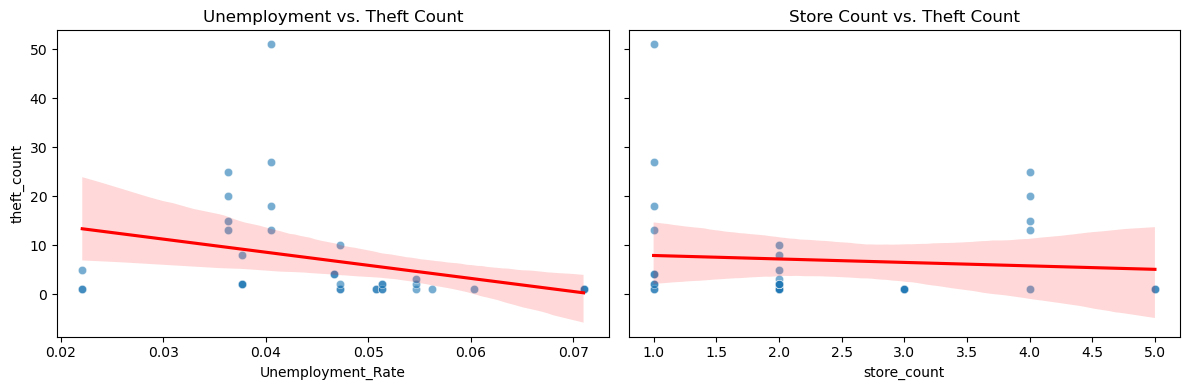

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

# Unemployment vs Theft
sns.scatterplot(x='Unemployment_Rate', y='theft_count',
                data=model_df, ax=axes[0], alpha=0.6)
axes[0].set_title('Unemployment vs. Theft Count')
sns.regplot(x='Unemployment_Rate', y='theft_count',
            data=model_df, ax=axes[0], scatter=False, color='red')

# Stores vs Theft
sns.scatterplot(x='store_count', y='theft_count',
                data=model_df, ax=axes[1], alpha=0.6)
axes[1].set_title('Store Count vs. Theft Count')
sns.regplot(x='store_count', y='theft_count',
            data=model_df, ax=axes[1], scatter=False, color='red')

plt.tight_layout()

#### 5.3.2 Univariate OLS

In [36]:
# Univariate OLS
m1 = smf.ols('theft_count ~ store_count',       data=model_df).fit()
m2 = smf.ols('theft_count ~ Unemployment_Rate', data=model_df).fit()

print("=== Store only ===\n", m1.summary())
print("\n=== Unemployment only ===\n", m2.summary())


=== Store only ===
                             OLS Regression Results                            
Dep. Variable:            theft_count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2136
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.647
Time:                        20:15:21   Log-Likelihood:                -131.64
No. Observations:                  35   AIC:                             267.3
Df Residuals:                      33   BIC:                             270.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.5860      3.

In [37]:
# Compare R² (or adj. R²) from the two models
print(f"R² store-only: {m1.rsquared:.3f}")
print(f"R² unemp-only: {m2.rsquared:.3f}")


R² store-only: 0.006
R² unemp-only: 0.095


In [38]:
# Multivariate OLS (both predictors)
m_full = smf.ols('theft_count ~ store_count + Unemployment_Rate', data=model_df).fit()
print(m_full.summary())


                            OLS Regression Results                            
Dep. Variable:            theft_count   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.713
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.196
Time:                        20:17:40   Log-Likelihood:                -129.97
No. Observations:                  35   AIC:                             265.9
Df Residuals:                      32   BIC:                             270.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            19.9086      7.38

From these OLS results we can see:
- Store‐only model: R² ≈ 0.006 (Adj R² = –0.024), p = 0.647 for the store_count coefficient. Virtually no explanatory power.
- Unemployment‐only model: R² ≈ 0.095 (Adj R² = 0.067), p ≈ 0.072 for the Unemployment_Rate coefficient. A small (~10%) share of variance is explained, and the negative slope (≈ –267) is marginally non‐significant at the 5% level.
- Full model (both predictors): R² ≈ 0.097 (Adj R² = 0.040), p ≈ 0.196 for the overall F-test, and neither coefficient is significant once both are included.

**Interpretation**
Unemployment rate shows a modest negative association with theft counts (higher unemployment → fewer thefts), whereas convenience‐store density has effectively no linear relationship. Adding both together barely improves fit beyond the univariate unemployment model.

#### 5.3.3 Test for Spatial Autocorrelation

In [53]:
# 1) Merge geometry from sa2_df into sa2_full
sa2_full_geo = sa2_hamilton.merge(
    sa2_df[['SA22023_V1','geometry']],
    on='SA22023_V1',
    how='left'
)

# build Queen contiguity weights on our GeoDataFrame
model_gdf = sa2_full_geo.dropna(subset=['store_count','Unemployment_Rate','theft_count'])
w = weights.Queen.from_dataframe(model_df)
w.transform = 'r'

# 1) Moran’s I on raw theft counts
mi_raw = esda.Moran(model_df['theft_count'].values, w)
print(f"Moran’s I (raw theft): {mi_raw.I:.3f}, p-value = {mi_raw.p_sim:.3f}")

# 2) Moran’s I on residuals of the full OLS model
resid = m_full.resid.values
mi_res = esda.Moran(resid, w)
print(f"Moran’s I (OLS residuals): {mi_res.I:.3f}, p-value = {mi_res.p_sim:.3f}")

KeyError: "['geometry'] not in index"

In [40]:
# Spatial autocorrelation of the full-model residuals
resids = m_full.resid.values
moran_res = esda.Moran(resids, w)
print(f"Moran’s I (residuals): {moran_res.I:.3f}, p-value: {moran_res.p_sim:.3f}")


NameError: name 'w' is not defined